<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Задача" data-toc-modified-id="Задача-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Задача</a></span></li><li><span><a href="#Загрузки" data-toc-modified-id="Загрузки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузки</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Заполняем-пропуски" data-toc-modified-id="Заполняем-пропуски-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Заполняем пропуски</a></span></li><li><span><a href="#Строим-графики" data-toc-modified-id="Строим-графики-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Строим графики</a></span></li><li><span><a href="#Анализ-торговых-стратегий" data-toc-modified-id="Анализ-торговых-стратегий-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Анализ торговых стратегий</a></span><ul class="toc-item"><li><span><a href="#Создаем-df-для-работы" data-toc-modified-id="Создаем-df-для-работы-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Создаем df для работы</a></span></li><li><span><a href="#Тест?" data-toc-modified-id="Тест?-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Тест?</a></span></li></ul></li></ul></div>

# Оценка качества

## Задача

Тестирование торговой стратегии на базе предобученного трансформера.

## Загрузки

In [2]:
# pip install "C:\YandexDisk\Code\Data&Lib_Arсhive\Ta-lib\ta_lib-0.5.1-cp312-cp312-win_amd64.whl"

In [3]:
'''Системные'''
import os
import sys
from datetime import datetime, timezone, timedelta
import time
from tqdm import tqdm 
import warnings

'''База'''
import pandas as pd
import numpy as np
from itertools import chain, combinations
from scipy import stats

'''Графики'''
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


'''Обучение'''
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

'''Подготовка'''
from tinkoff.invest import Client, CandleInterval
from pybit.unified_trading import HTTP

'''Торговые агенты'''
import talib
from backtesting.lib import crossover
from backtesting import Backtest, Strategy








C:\Users\fd\anaconda3\envs\work_env\Lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [4]:
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("api_key_bybit")
api_secret = os.getenv("api_secret_bybit")
api_T = os.getenv("TOKEN_T")

In [5]:
tickers_crypt = ['BTCUSDT', 'ETHUSDT']
tickers = ["SBER", "XAU", "PLZL", "MGNT", "SBER", "YDEX"]
output_crypt_file = 'crypto_data.csv'
output_file = 'ticker_data.csv'
all_data = []
all_data_crypt = []
end_date = datetime.today().strftime('%dd-%mm-%YY')
start_date = (datetime.today() - timedelta(days=(0.3 * 365))).strftime('%dd-%mm-%YY')
start_dt = datetime.strptime(start_date, '%dd-%mm-%YY')
end_dt = datetime.strptime(end_date, '%dd-%mm-%YY')

# Константы комиссий
COMMISSION_BUY = 0.003
COMMISSION_SELL = 0.002

N = 3

In [6]:
if os.path.exists(output_file):
    df = pd.read_csv(output_file, index_col=0)
    print("Данные успешно загружены:")
    display(df.head())

else: 
    data = []
    
    with Client(api_T) as client:
        try:
            for ticker in tqdm(tickers, desc="Загрузка данных", unit="тикер"):
                
                """ Сначала пытаемся найти акциb"""
                instrument = None
                shares = client.instruments.shares().instruments
                instrument = next((i for i in shares if i.ticker == ticker), None)
    
                """ Если не нашли как акцию, ищем другие инструменты"""
                if not instrument:
                    instrument_response = client.instruments.find_instrument(query=ticker)
                    instrument = next((i for i in instrument_response.instruments if i.ticker == ticker), None)
    
                if not instrument:
                    print(f"Инструмент {ticker} не найден.")
                    continue
    
                figi = instrument.figi
                candles = client.market_data.get_candles(
                    figi=figi,
                    from_=start_dt,
                    to=end_dt,
                    interval=CandleInterval.CANDLE_INTERVAL_DAY
                ).candles
    
                if not candles:
                    print(f"Нет данных по {ticker} за указанный период.")
                    continue
    
                for candle in candles:
                    candle_time = candle.time.astimezone(timezone.utc)
    
                    data.append({
                        'ticker': ticker,
                        'date': candle_time,
                        'open': candle.open.units + candle.open.nano / 1e9,
                        'high': candle.high.units + candle.high.nano / 1e9,
                        'low': candle.low.units + candle.low.nano / 1e9,
                        'close': candle.close.units + candle.close.nano / 1e9,
                        'volume': candle.volume
                    })
                df = pd.DataFrame(data)
                df['date'] = pd.to_datetime(df['date']).dt.tz_localize(None)
                df.to_csv(output_file, index=True)
                print("Данные успешно сохранены.")
        except Exception as e:
            print(f"Ошибка при обработке {ticker}: {e}")




Данные успешно загружены:


,ticker,date,open,high,low,close,volume
0,SBER,2025-04-10,294.09,296.75,288.27,292.46,6286284
1,SBER,2025-04-11,293.00,300.48,292.80,299.81,5041821
2,SBER,2025-04-12,300.18,301.80,300.03,300.95,461524
3,SBER,2025-04-13,300.88,301.99,300.01,301.49,407921
4,SBER,2025-04-14,301.49,302.40,295.13,296.50,3476895


In [7]:
"""Проверяем, какие тикеры загрузили"""
df.ticker.unique()

array(['SBER', 'XAU', 'PLZL', 'MGNT', 'YDEX'], dtype=object)

In [8]:
if os.path.exists(output_crypt_file):
    df_crypt = pd.read_csv(output_crypt_file, index_col=0)
    print("Данные успешно загружены:")
    display(df_crypt.head())

else: 
    client = HTTP()
    try:
        for ticker in tqdm(tickers_crypt, desc='Загрузка крипто-данных', unit='тикер'):
            response = client.get_kline(
                category='linear',
                symbol=ticker,
                interval='D',
                start=int(start_dt.timestamp() * 1000),
                end=int(end_dt.timestamp() * 1000)
            )
            candles = response.get('result', {}).get('list', [])
    
            if not candles:
                print(f"Нет данных по {ticker} за указанный период.")
                continue
    
            for candle in candles:
                candle_time = datetime.utcfromtimestamp(int(candle[0]) / 1000)
    
                all_data_crypt.append({
                    'ticker': ticker,
                    'date': candle_time,
                    'open': float(candle[1]),
                    'high': float(candle[2]),
                    'low': float(candle[3]),
                    'close': float(candle[4]),
                    'volume': float(candle[5])
                })
    
        df_crypt = pd.DataFrame(all_data_crypt)
        df_crypt.to_csv(output_crypt_file, index=True)
        print("Крипто-данные успешно сохранены.")
    
    except Exception as e:
        print(f"Ошибка при обработке {ticker}: {e}")


Данные успешно загружены:


,ticker,date,open,high,low,close,volume
0,BTCUSDT,2025-07-28,119429.9,119844.9,117401.5,118068.9,55237.020
1,BTCUSDT,2025-07-27,117898.8,119784.0,117807.6,119429.9,35559.539
2,BTCUSDT,2025-07-26,117616.3,118333.4,117150.0,117898.8,26231.010
3,BTCUSDT,2025-07-25,118328.0,118440.3,114710.0,117616.3,121212.765
4,BTCUSDT,2025-07-24,118743.4,119492.9,117050.1,118328.0,68946.070


In [9]:
# df['date'] = df['date'].replace(tzinfo=None)
df = pd.concat([df, df_crypt], ignore_index=True)


## EDA

In [10]:
def viewing_statistics(df_list):
    print('Посмотрим на данные:')
    for i in table:
        if len(i) >= 3:
            display(i.sample(3))
        else:
            display(i)
        display(i.info())
        display(i.columns)
        print('\n')
table = [df]   
viewing_statistics(table)

Посмотрим на данные:


,ticker,date,open,high,low,close,volume
287,PLZL,2025-07-10,1830.0,1877.2,1822.8,1860.8,583113.000
705,BTCUSDT,2025-04-21,85145.5,88442.9,85106.1,87471.1,129404.128
84,SBER,2025-07-12,310.0,311.0,310.0,310.2,87372.000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  825 non-null    object 
 1   date    825 non-null    object 
 2   open    825 non-null    float64
 3   high    825 non-null    float64
 4   low     825 non-null    float64
 5   close   825 non-null    float64
 6   volume  825 non-null    float64
dtypes: float64(5), object(2)
memory usage: 45.2+ KB


None

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

In [11]:
print('Проверим пропуски:')
for i in table:
    display(i.isnull().mean().sort_values())

Проверим пропуски:


ticker    0.0
date      0.0
open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
dtype: float64

## Заполняем пропуски
пока нет, что бы не забыть оставлю.

In [12]:
df = df.fillna(method='ffill')
df = pd.DataFrame(df.replace(to_replace=0, method='ffill'))

C:\Users\fd\AppData\Local\Temp\ipykernel_33504\4089252463.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
C:\Users\fd\AppData\Local\Temp\ipykernel_33504\4089252463.py:2: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df = pd.DataFrame(df.replace(to_replace=0, method='ffill'))


## Строим графики

In [13]:
fig = go.Figure()
df.columns = df.columns.str.capitalize()
for ticker in df['Ticker'].unique():
    _ = df[df['Ticker'] == ticker].copy()
    
    '''Убираю ошибку с лишней линией, проверю дубликаты и пропуски после'''
    _ = _.drop_duplicates(subset=['Date']).sort_values(by='Date')
    if _['Close'].isnull().any():
        _['Close'] = _['Close'].fillna(method='ffill')  # Заполнение пропусков предыдущим значением
    

    _['Growth'] = (_['Close'] / _['Close'].iloc[0]) * 100  # Нормализация, первое значение = 100%
    fig.add_trace(go.Scatter(
        x=_['Date'],
        y=_['Growth'],
        mode='lines',
        name=ticker,
    ))

fig.update_layout(
    template="plotly_dark",
    title="Темпы прироста всех тикеров (нормализация к 100%)",
    title_x=0.5,
    xaxis_title="Дата",
    yaxis_title="Темп прироста (%)",
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    font=dict(size=14),
)

fig.show()


## Анализ выбросов

In [14]:
df_0 = df.copy()
df = df[df['Ticker'] == 'SBER']
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [15]:
df['Outlier'] = False  # зануляем стартовое значение


numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# --- Метод 1: Z-оценка ---
z_threshold = 4

z_scores = np.abs(stats.zscore(df[numeric_cols], nan_policy='omit'))
z_outliers = (z_scores > z_threshold).any(axis=1)

# --- Метод 2: IQR ---
iqr_outliers = pd.Series([False] * len(df))

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    iqr_outliers |= (df[col] < lower) | (df[col] > upper)

# Объединяем оба метода (можно использовать только один по желанию)
df['Outlier'] = iqr_outliers | z_outliers #


outliers_df = df[df['Outlier'] == True]
print(f"Найдено выбросов: {len(outliers_df)}")

Найдено выбросов: 4


In [16]:
df['Date'] = pd.to_datetime(df['Date']) 
df.set_index('Date', inplace=True)

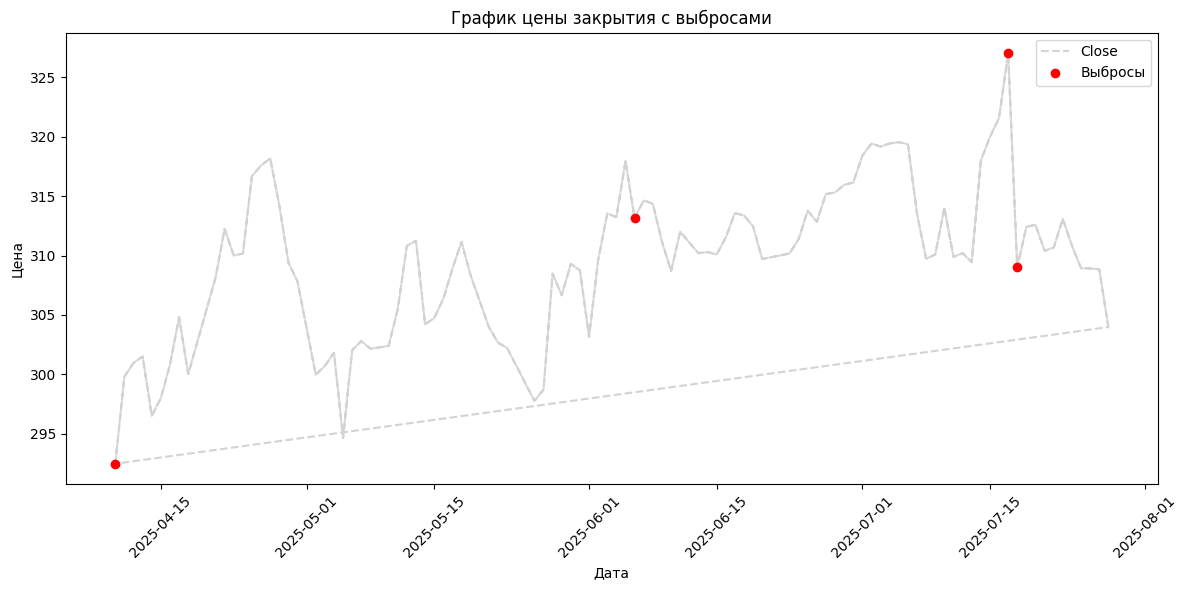

In [17]:
resampled_df = df.copy()
resampled_df['MA_5'] = resampled_df['Close'].rolling(window=5).mean()

outliers = df[df['Outlier'] == True].copy()

plt.figure(figsize=(12, 6))

plt.plot(df.index, df['Close'], label='Close', color='lightgray', linestyle='--')

plt.scatter(outliers.index, outliers['Close'], color='red', label='Выбросы', zorder=5)
plt.xticks(rotation=45) 

plt.title("График цены закрытия с выбросами")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.legend()
plt.tight_layout()
plt.show()

## Модель с трансформером

In [18]:
# !git clone https://github.com/thuml/Time-Series-Library.git

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(f"✅ Найден GPU: {torch.cuda.get_device_name(0)}")
else:
    print("⚠️ GPU не найден, будет использоваться CPU")

project_path = r'C:\YandexDisk\Code\education\FinML\Time-Series-Library' 
if not os.path.isdir(project_path):
    raise FileNotFoundError(f"Ошибка: Папка проекта не найдена по пути '{project_path}'.")
if project_path not in sys.path:
    sys.path.append(project_path)
    print(f"Путь '{project_path}' успешно добавлен в sys.path.")

try:
    from models.TimesNet import Model as TimesNetModel
    print("Модель TimesNet успешно импортирована.")
except (ModuleNotFoundError, ImportError) as e:
    print(f"Критическая ошибка импорта: {e}")
    exit()


⚠️ GPU не найден, будет использоваться CPU
Путь 'C:\YandexDisk\Code\education\FinML\Time-Series-Library' успешно добавлен в sys.path.
Модель TimesNet успешно импортирована.


In [20]:
threshold = 0.001
df["target"] = 0
df.loc[df["Close"].shift(-3) > df["Close"] * (1 + threshold), "target"] = 1
df.loc[df["Close"].shift(-3) < df["Close"] * (1 - threshold), "target"] = -1
df.dropna(subset=["target"], inplace=True)
df["target"] = df["target"] + 1
df["target"] = df["target"].astype(int)
df = df.iloc[:-1]

for i in range(1, 6):
    df[f'Close_lag_{i}'] = df['Close'].shift(i)
df['SMA_10'] = df['Close'].rolling(window=10).mean()
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))
df.dropna(inplace=True)

features = [col for col in df.columns if col != 'target']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])



def create_sequences(input_data, target_data, window_size):
    X, y = [], []
    for i in range(len(input_data) - window_size):
        X.append(input_data[i:i + window_size])
        y.append(target_data[i + window_size])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int64)

window_size = 10
X_all, y_all = create_sequences(df[features].values, df['target'].values, window_size)

train_size = int(len(X_all) * 0.7)
val_size = int(len(X_all) * 0.15)
X_train, y_train = X_all[:train_size], y_all[:train_size]
X_val, y_val = X_all[train_size:train_size + val_size], y_all[train_size:train_size + val_size]
X_test, y_test = X_all[train_size + val_size:], y_all[train_size + val_size:]

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

print("\n--- Баланс классов в обучающей выборке ---")
class_counts = np.bincount(y_train)
class_names = ['Sell', 'Hold', 'Buy'] 
for i, count in enumerate(class_counts):
    print(f"Класс '{class_names[i]}': {count} примеров")


batch_size = 16

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_dataset = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)




Train: (54, 10, 13), Val: (11, 10, 13), Test: (13, 10, 13)

--- Баланс классов в обучающей выборке ---
Класс 'Sell': 21 примеров
Класс 'Hold': 3 примеров
Класс 'Buy': 30 примеров


In [21]:
class TimesNetForClassification(nn.Module):
    def __init__(self, configs, num_classes):
        super().__init__()
        # Инициализируем базовую модель TimesNet, чтобы получить доступ к ее слоям
        self.timesnet = TimesNetModel(configs)
        
        # Добавляем слой для адаптации
        self.flatten = nn.Flatten()
        self.classification_head = nn.Linear(configs.seq_len * configs.d_model, num_classes)

    def forward(self, x_enc):
        # 1. Получаем эмбеддинги входных данных
        enc_out = self.timesnet.enc_embedding(x_enc, None)

        # 2. Пропускаем эмбеддинги через основные блоки TimesNet. т.к. self.timesnet.model - это nn.ModuleList, то используем цикл?
        for layer in self.timesnet.model:
            enc_out = layer(enc_out)
        
        # 3. Превращаем в одномерный вектор
        x = self.flatten(enc_out)
        
        # 4. Пропускаем вектор признаков через слой классификации
        output = self.classification_head(x)
        
        return output

# Конфигурация TimesNet
class Config:
    task_name = 'classification'
    seq_len = window_size
    pred_len = 0
    label_len = 3
    enc_in = len(features)
    d_model = 64
    e_layers = 2
    d_ff = 64
    top_k = 5
    dropout = 0.1
    num_class = 3
    num_kernels = 6
    embed = 'timeF'
    freq = 'h'
    activation = 'gelu'
    factor = 3
    batch_size = 32
    learning_rate = 1e-4
    train_epochs = 10
    patience = 3
    gpu = 0
    use_amp = False
    moving_avg = 10

configs = Config()
model = TimesNetForClassification(configs, num_classes=3).to(device)

In [22]:
epochs = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    # DataLoader возвращает только данные и метки класса
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Вызов модели
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Валидация
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    
    print(f'Эпоха [{epoch+1}/{epochs}], Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Эпоха [1/10], Loss: 1.2165, Val Loss: 1.3820, Val Acc: 45.45%
Эпоха [2/10], Loss: 0.9672, Val Loss: 1.2547, Val Acc: 45.45%
Эпоха [3/10], Loss: 0.7648, Val Loss: 1.2184, Val Acc: 45.45%
Эпоха [4/10], Loss: 0.7942, Val Loss: 1.0929, Val Acc: 45.45%
Эпоха [5/10], Loss: 0.7846, Val Loss: 1.0155, Val Acc: 54.55%
Эпоха [6/10], Loss: 0.7794, Val Loss: 1.1546, Val Acc: 45.45%
Эпоха [7/10], Loss: 0.8456, Val Loss: 1.2570, Val Acc: 45.45%
Эпоха [8/10], Loss: 0.7293, Val Loss: 1.0145, Val Acc: 45.45%
Эпоха [9/10], Loss: 0.7051, Val Loss: 1.1079, Val Acc: 45.45%
Эпоха [10/10], Loss: 0.7778, Val Loss: 1.3588, Val Acc: 45.45%


In [23]:
model.eval()
all_preds = []
with torch.no_grad():
    for inputs, _ in test_loader: 
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())

pred_labels = np.array(all_preds)
signals = pred_labels - 1 

print("\n--- Отчет по классификации TimesNet ---")
print(classification_report(
    y_test - 1, 
    signals, 
    labels=[-1, 0, 1], 
    target_names=['Sell', 'Hold', 'Buy']
))



--- Отчет по классификации TimesNet ---
              precision    recall  f1-score   support

        Sell       0.00      0.00      0.00        10
        Hold       0.00      0.00      0.00         0
         Buy       0.23      1.00      0.38         3

    accuracy                           0.23        13
   macro avg       0.08      0.33      0.12        13
weighted avg       0.05      0.23      0.09        13



C:\Users\fd\anaconda3\envs\work_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\fd\anaconda3\envs\work_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\fd\anaconda3\envs\work_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\fd\anaconda3\envs\work_env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division

In [24]:
combined_df = df.iloc[train_size+val_size+window_size:].copy()
signals = signals[:len(combined_df)]
combined_df['Signal'] = signals

class MyStrategy(Strategy):
    def init(self):
        self.signal = self.I(lambda x: x, self.data.Signal)

    def next(self):
        if self.signal[-1] == 1 and not self.position.is_long:
            self.buy()
        elif self.signal[-1] == -1 and not self.position.is_short:
            self.sell()
        elif self.signal[-1] == 0:
            self.position.close()

backtest = Backtest(
    combined_df,
    MyStrategy,
    cash=10000,
    commission=0.002,
    exclusive_orders=True
)

result = backtest.run()
print("\n--- Результаты бэктестинга ---")
print(result)
backtest.plot(plot_equity=True, plot_drawdown=True, relative_equity=False, resample=False)

Backtest.run:   0%|          | 0/12 [00:00<?, ?bar/s]


--- Результаты бэктестинга ---
Start                     2025-07-16 00:00:00
End                       2025-07-28 00:00:00
Duration                     12 days 00:00:00
Exposure Time [%]                         0.0
Equity Final [$]                   13181.0525
Equity Peak [$]                   26051.14106
Return [%]                           31.81053
Buy & Hold Return [%]               -65.36748
Return (Ann.) [%]                233154.18764
Volatility (Ann.) [%]     38536888963998.3...
CAGR [%]                         445024.91479
Sharpe Ratio                              0.0
Sortino Ratio                      1054.38137
Calmar Ratio                        4719.4179
Alpha [%]                            12.74859
Beta                                 -0.29161
Max. Drawdown [%]                   -49.40317
Avg. Drawdown [%]                   -30.77735
Max. Drawdown Duration        5 days 00:00:00
Avg. Drawdown Duration        4 days 00:00:00
# Trades                                    0
Wi

C:\Users\fd\AppData\Local\Temp\ipykernel_33504\746017852.py:25: UserWarning:

Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.



GridPlot(id='p1267', ...)

## Вывод:

Модель трансформер не показала устойчивого результата. При текущем варианте запуска стратегия выиграла у buy&hold